In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Load Dataset

In [94]:
train_data = np.load('s2_train.npy',allow_pickle=True)
test_data = np.load('s2_test.npy',allow_pickle=True)

### Sample of the PPG signal

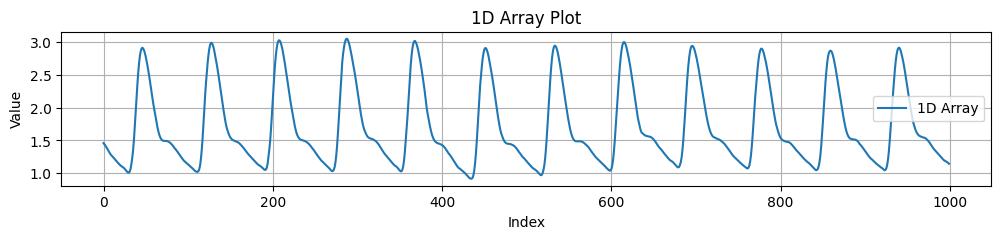

In [95]:
plt.figure(figsize=(12,2))  # Optional: Set the figure size
plt.plot((train_data[0,0])[0:1000] , label='1D Array')  # Plot the 1D array
plt.title('1D Array Plot')  # Set the title
plt.xlabel('Index')  # Set the X-axis label (index in this case)
plt.ylabel('Value')  # Set the Y-axis label (values from the array)
plt.legend()  # Show legend

# Show the plot
plt.grid()  # Optional: Add gridlines
plt.show()

## Separate PPG Signal(length=10s)

In [96]:
n=125*10
i=0
data=np.ones((np.size(train_data[1][0])//n,n))
for i in range(np.size(train_data[1][0])//n):
    if i==np.size(train_data[1][0])//n:
        data[i][:] =(train_data[1][0])[n*i:]
    else:
        data[i][:]=(train_data[1][0])[n*i:n*(i+1)]

## PDF Report- Plot All Signals in the PDF File

In [97]:
with PdfPages(r'ppg.pdf') as export_pdf:
    s=0
    for t in range(np.size(train_data[1][0])//n//6):
        plt.figure(figsize=(20,18))
        for i in range(6):
            plt.subplot(6,1,i+1)
            plt.plot(data[s], color='red')
            plt.title(s)
            s+=1
        plt.suptitle("PPG signal")
        plt.tight_layout()
        export_pdf.savefig()
        plt.close()

## Find Signals Peak

### Separate PPG Signal(peak number=10)


In [30]:
!pip install pyampd

In [98]:
from pyampd.ampd import find_peaks

data_ampd = []
c = 0

for n in range(50):
    ppg = []
    ppg = train_data[n][0]
    peaks = find_peaks(ppg, scale=100)
    for i in range(np.size(peaks)//10):
        if i == np.size(peaks)//10:
            data_ampd.append((train_data[n][0])[peaks[i*10]-30:peaks[(i+1)*10-1]])
        else:
            data_ampd.append((train_data[n][0])[peaks[i*10]-30:peaks[(i+1)*10-1]+30])
        c+=1

pb_ampd=[]
c=0

for n in range(50):
    pb = []
    pb = train_data[n][1]
    peaks = find_peaks(pb, scale=100)
    for i in range(np.size(peaks)//10):
        if i == np.size(peaks)//10:
            pb_ampd.append((data[n][1])[peaks[i*10]-30:peaks[(i+1)*10-1]])
        else:
            pb_ampd.append((train_data[n][1])[peaks[i*10]-30:peaks[(i+1)*10-1]+30])
        c += 1

In [116]:
#find peaks & separate test signal
test_ampd=[]
c=0

for n in range(5):
    ppg=[]
    ppg=test_data[n][0]
    peaks = find_peaks(ppg, scale=100)
    for i in range(np.size(peaks)//10):
        if i==np.size(peaks)//10:
            test_ampd.append((test_data[n][0])[peaks[i*10]-30:peaks[(i+1)*10-1]])
        else:
            test_ampd.append((test_data[n][0])[peaks[i*10]-30:peaks[(i+1)*10-1]+30])
        c+=1

##Separate BP Signal(peak number=10)
###Finding Valleys and Peaks

In [35]:
!pip install peakdetect

In [99]:
from peakdetect import peakdetect

systolic=[]
diastolic=[]
c=0

for n in range(50):
    seq = []
    bp = []
    bp = train_data[n][1]
    peaks = find_peaks(bp, scale=100)

    for i in range(np.size(peaks)//10):
        mean=0
        for j in range(10):
            mean += (train_data[n][1])[peaks[i*10+j]]
        systolic.append(mean/10)
        seq = bp[peaks[i*10]:peaks[(i+1)*10-1]]
        peaks_ = peakdetect(seq, lookahead=40)
        low_peaks = peaks_[1]
        avr=0

        for k in range(np.shape(low_peaks)[0]):
            avr += low_peaks[k][1]
        diastolic.append(avr/np.shape(low_peaks)[0])
        c+=1

## Base_line
### Calculate Systolic & Diastolic Average(base line)

In [100]:
sys_mean = 0
dia_mean = 0

for i in range(np.size(systolic)):
    sys_mean += systolic[i]
    dia_mean += diastolic[i]

sys_mean /= np.size(systolic)
dia_mean /= np.size(diastolic)
print('systolic mean',sys_mean)
print('diastolic mean',dia_mean)

systolic mean 130.86744630750317
diastolic mean 65.33401277257616


### Calculate Base Line RMSE

In [101]:
sys_rmse = 0
dia_rmse = 0

for i in range(np.size(systolic)):
    sys_rmse += (systolic[i]-sys_mean)**2
    dia_rmse += (diastolic[i]-dia_mean)**2

#calculate base line RMSE
sys_rmse_base_line = np.sqrt(sys_rmse/np.size(systolic))
dia_rmse_base_line = np.sqrt(dia_rmse/np.size(systolic))
print('systolic RMSE error(base_line)=',sys_rmse_base_line)
print('diastolic RMSE error(base_line)=',dia_rmse_base_line)

systolic RMSE error(base_line)= 22.23712522051115
diastolic RMSE error(base_line)= 7.271618681512604


## Upsampling - set signals' length to 1200 ms

In [102]:
def upsample_signal(signal, target_length):
    # Calculate the factor by which to upsample the signal
    upsample_factor = target_length / len(signal)

    # Create an array with the target length
    upsampled_signal = np.zeros(target_length)

    # Linearly interpolate the values
    for i in range(target_length):
        index = i / upsample_factor
        lower_index = int(index)
        upper_index = min(lower_index + 1, len(signal) - 1)
        fractional_part = index - lower_index

        if lower_index == upper_index:
            upsampled_signal[i] = signal[lower_index]
        else:
            upsampled_signal[i] = (1 - fractional_part) * signal[lower_index] + fractional_part * signal[upper_index]

    return upsampled_signal

### Upsampling the training set

In [103]:
target_length = 1200

for i in range(np.size(data_ampd)):
  if len(data_ampd[i]) !=0:
    data_ampd[i] = upsample_signal(data_ampd[i], target_length)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


### Upsampling the test set

In [117]:
target_length = 1200

for i in range(np.size(test_ampd)):
  if len(test_ampd[i]) !=0:
    test_ampd[i] = upsample_signal(test_ampd[i], target_length)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


### Deleting the empty arrays of the training dataset

In [108]:
zeros_idx = []
for i in range(np.size(data_ampd)):

  if (np.size(data_ampd[i]) != 1200):

    zeros_idx.append(i)


data_ampd = np.delete(data_ampd, zeros_idx)
data_ampd = np.delete(data_ampd, -1)
systolic = np.delete(systolic, zeros_idx)
diastolic = np.delete(diastolic, zeros_idx)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### Deleting the empty arrays of the test dataset

In [119]:
test_zeros_idx = []
for i in range(np.size(test_ampd)):

  if (np.size(test_ampd[i]) != 1200):

    test_zeros_idx.append(i)

test_ampd = np.delete(test_ampd, test_zeros_idx)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## Linear Regression

In [120]:
#y_train = np.ones((np.shape(data_ampd)[0]))
X_test = np.ones((np.size(test_ampd),1200))

for i in range(np.shape(train_data)[0]):
   #y_train[i] = train_data[i][1]
   X_test[i] = test_ampd[i]

In [111]:
#y_train = np.ones((np.shape(data_ampd)[0]))
X_train = np.ones((np.size(data_ampd),1200))

for i in range(np.shape(train_data)[0]):
   #y_train[i] = train_data[i][1]
   X_train[i] = data_ampd[i]

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math


# Initialize the linear regression model
systolic_model = LinearRegression()
diastolic_model = LinearRegression()

# Train the model on the training data
systolic_model.fit(X_train, systolic)
diastolic_model.fit(X_train, diastolic)

#Make predictions on the test data
systolic_y_train_pred = systolic_model.predict(X_train)
diastolic_y_train_pred = diastolic_model.predict(X_train)

# Calculate Mean Squared Error (MSE)
systolic_mse = mean_squared_error(systolic, systolic_y_train_pred)
diastolic_mse = mean_squared_error(diastolic, diastolic_y_train_pred)

# Calculate Root Mean Square Error (RMSE)
systolic_rmse = np.sqrt(systolic_mse)
diastolic_rmse = np.sqrt(diastolic_mse)

print("SYSTOLIC_MSE:", systolic_mse)
print("SYSTOLIC_RMSE:", systolic_rmse)

print("DIASTOLIC_MSE:", diastolic_mse)
print("DIASTOLIC_RMSE:", diastolic_rmse)


#Make predictions on the test data
systolic_y_pred = systolic_model.predict(X_test)
diastolic_y_pred = diastolic_model.predict(X_test)

file_name = "linear_regression_systolic_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, systolic_y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")

SYSTOLIC_MSE: 493.8063554843085
SYSTOLIC_RMSE: 22.221754104577535
DIASTOLIC_MSE: 52.087745267714865
DIASTOLIC_RMSE: 7.217184026177722
Array saved to systolic_prediction.txt


## Ridge Regression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from numpy import arange
from sklearn.model_selection import GridSearchCV

# define models
systolic_model = Ridge(alpha=1.0)
diastolic_model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
systolic_model = GridSearchCV(systolic_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
diastolic_model = GridSearchCV(diastolic_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Train the model on the training data
systolic_model.fit(X_train, systolic)
diastolic_model.fit(X_train, diastolic)

#Make predictions on the test data
systolic_y_train_pred = systolic_model.predict(X_train)
diastolic_y_train_pred = diastolic_model.predict(X_train)

# Calculate Mean Squared Error (MSE)
systolic_mse = mean_squared_error(systolic, systolic_y_train_pred)
diastolic_mse = mean_squared_error(diastolic, diastolic_y_train_pred)

# Calculate Root Mean Square Error (RMSE)
systolic_rmse = np.sqrt(systolic_mse)
diastolic_rmse = np.sqrt(diastolic_mse)

print("SYSTOLIC_MSE:", systolic_mse)
print("SYSTOLIC_RMSE:", systolic_rmse)

print("DIASTOLIC_MSE:", diastolic_mse)
print("DIASTOLIC_RMSE:", diastolic_rmse)


#Make predictions on the test data
systolic_y_pred = systolic_model.predict(X_test)
diastolic_y_pred = diastolic_model.predict(X_test)

file_name = "ridge_regression_systolic_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, systolic_y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")

## Lasso

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso

# Define the Lasso regression model
systolic_lasso_model = Lasso()
diastolic_lasso_model = Lasso()

# Define the parameter grid for grid search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

# Create a k-fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
systolic_model = GridSearchCV(estimator=systolic_lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)
diastolic_model = GridSearchCV(estimator=diastolic_lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)

# Train the model on the training data
systolic_model.fit(X_train, systolic)
diastolic_model.fit(X_train, diastolic)

#Make predictions on the test data
systolic_y_train_pred = systolic_model.predict(X_train)
diastolic_y_train_pred = diastolic_model.predict(X_train)

# Calculate Mean Squared Error (MSE)
systolic_mse = mean_squared_error(systolic, systolic_y_train_pred)
diastolic_mse = mean_squared_error(diastolic, diastolic_y_train_pred)

# Calculate Root Mean Square Error (RMSE)
systolic_rmse = np.sqrt(systolic_mse)
diastolic_rmse = np.sqrt(diastolic_mse)

print("SYSTOLIC_MSE:", systolic_mse)
print("SYSTOLIC_RMSE:", systolic_rmse)

print("DIASTOLIC_MSE:", diastolic_mse)
print("DIASTOLIC_RMSE:", diastolic_rmse)


#Make predictions on the test data
systolic_y_pred = systolic_model.predict(X_test)
diastolic_y_pred = diastolic_model.predict(X_test)

file_name = "lasso_systolic_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, systolic_y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")